In [187]:
from numpy.random import normal,multivariate_normal
import numpy as np
from numpy.linalg import inv
from scipy import *
from scipy.linalg import norm, pinv
from scipy.misc import derivative
from sympy import symbols, diff
import matplotlib.pyplot as plt
import numdifftools as nd
np.random.seed(0)

def flatten_function(l):
    return [item for sublist in l for item in sublist]

def flatten_args(l):
    ret = [[l[0]]] #l[0] is k
    ret.append(list(l[1]))
    return flatten_function(ret)

def partial_function(f___,input,pos,value):
    tmp  = input[pos]
    input[pos] = value
    ret = f___(*input)
    input[pos] = tmp
    return ret

def partial_derivative(f,input,wrt): #wrt = with respect to (partial derivative wrt x_k, for instance)
    ret = np.empty(len(input))
    for i in range(len(input)):
        fg = lambda x:partial_function(f,input,i,x)
        ret[i] = nd.Derivative(fg)(input[i])
#     print("ret",ret)
    if wrt == -1:
        return ret
    else:
        return ret[wrt]

def partial_derivative_multi(f,input,wrt): #for that, we need f to be a list of functions, representing the compponents
    if len(f) == 1: #this "if" should make the program crash if f has only one component. 
                    #use partial_derivative function in this case
        print("one dimension")
        return
    input_flatten = flatten_args(input)
#     print("more than one dimension")
    ret = []
    for f_component in f:
        ret.append(partial_derivative(f_component,input_flatten,wrt=-1))
    ret = np.array(ret)
#     print(ret.shape)
#     print("entire partial derivative",ret)
#     print("returned",ret[:,wrt:])
    return ret[:,wrt:]

def evaluate_f(f,value,multiDimensional = False):
    k_value = value[0]
    x_flattened = [el for el in value[1]]
    if multiDimensional == False:
        return f(*value)
    else:
        value_flatten = flatten_args(value)
        return [f_component(*value_flatten) for f_component in f] 

# print(evaluate_f(f,[1,0],multiDimensional))    

def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,x.shape[1]))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err    

def extended_KF(x0,y,T,f,h,R,Q,StateDimension,OutputDimension):

    #Initialization
    V = np.zeros([T,StateDimension,StateDimension])
    V[0] = np.identity(StateDimension)
    x_f = np.zeros([T,StateDimension])
    x_f[0] = x0
    
    V_plus_all = np.zeros([T,StateDimension,StateDimension])
    A_all = np.zeros([T,StateDimension,StateDimension])
    C_all = np.zeros([T,OutputDimension,StateDimension])
    x_plus_all = np.zeros([T,StateDimension])

    #Propagation
    for k in range(1,T):  
#         print(x_f[k-1])
#         A_all[k-1] = np.matrix(partial_derivative(f,np.array([k-1,x_f[k-1]]))[1])  #derivative of f, wrt x_k
        A_all[k-1] = np.matrix(partial_derivative_multi(f,[k-1,x_f[k-1]],wrt=1)) #derivative of f, wrt x_k
        x_plus = evaluate_f(f,[k-1,x_f[k-1]],multiDimensional)
        x_plus_all[k] = x_plus
#         C_all[k] = np.matrix(partial_derivative(h,np.array([k,x_plus]))[1]) #derivative of h, with respect to x_k
        C_all[k] = np.matrix(partial_derivative_multi(h,[k,x_plus],wrt=1)) #derivative of h, wrt x_k
        V_plus = np.matrix(A_all[k-1].dot(V[k-1])).dot(A_all[k-1].T) + Q 
        V_plus_all[k] = V_plus
                
        K = V_plus.dot(C_all[k].T).dot(inv(C_all[k].dot(V_plus.dot(C_all[k].T)) + R))
        x_f[k] = x_plus + K.dot(y[k] - evaluate_f(h,[k,x_plus],multiDimensional))
        V[k] = (np.identity(K.shape[0]) - K.dot(C_all[k])).dot(V_plus)

#     A_all[T-1] = np.matrix(partial_derivative(f,np.array([T-1,x_f[T-1]]))[1]) #derivative of f, with respect to x_k
    A_all[T-1] = np.matrix(partial_derivative_multi(f,[T-1,x_f[T-1]],wrt=1)) #derivative of f, with respect to x_k
    
    #Recursive
    #F = A, B = H, P = V

    #Initialization
    x_b = np.zeros([T,StateDimension])
    x_b[T-1] = x_f[-1]
    V_b = np.zeros([T,StateDimension,StateDimension])
    V_b[-1] = V[-1]

    #Propagation
    #Remark: compared to the table 1.2 on page 17, we changed all the indexes by -1
    for k in range(T-1, 0, -1): #from T-1 to 1 by -1 increments

        A_b = np.matrix(V[k-1].dot(A_all[k].T)).dot(inv(np.matrix(V_plus_all[k])))
        V_b[k-1] = V[k-1] - A_b.dot(V_plus_all[k] - V_b[k]).dot(A_b.T)
        x_b[k-1] = x_f[k-1] + A_b.dot(x_b[k] - x_plus_all[k])
    
    return x_f,x_b

def factor_analysis(X,m):
    #X is a d*n data matrix
    #m : dimension of target space (i.e reduced space)
    d = X.shape[0]
    n = X.shape[1]
    print("dimension of X",d)
    print("number of data in time series",n)
    
    mu = np.mean(X, axis = 1)
    
    
    print(d)
    print(n)
    #Mu = dot(mu, np.ones((n,),"float"))
    
    CenteredData = X

    for i in range(n):
        for j in range(d):
            CenteredData[j,i] = X[j,i]-mu[j]
        
    
    #The tolerance value
    tol = 1e-4
    
    #Maximum number of iteration
    maxiter = 50
    
    #Log-likelihood value
    llh = -1
    
    #Define identity matrix 
    I = np.identity(m)
    
    M = dot(CenteredData, np.transpose(CenteredData))
    r = M.diagonal()
    
    #Initialize the weight matrix
    W = np.random.rand(d,m)
    Wupdated = W
    
    #Psi is the diagonal covariance matrix, we store only a d-dimensional vector
    Psi = np.identity(d)
    
    for i in  range(d):
        Psi[i,i] = random.random()
    
    Psiupdated = Psi
    
    for iter in range(maxiter-1):
        Psi = Psiupdated
        W = Wupdated
        G = inv(I + dot(dot(np.transpose(W),inv(Psi)),W))
        R = dot(dot(np.transpose(W), inv(Psi)),CenteredData)
        
        #E-step
        Ez = dot(G,R)
        Ezz = G + dot(Ez, np.transpose(Ez))
        
        #M-step
        DataCovariance = np.cov(CenteredData)
        
        #Updated weights
        Wupdated = dot(CenteredData, np.transpose(Ez))
        Wupdated = dot(Wupdated, inv(Ezz))
        
        #Updated Psi
        V = np.diag(DataCovariance - (1/n)**dot(Wupdated,dot(Ez,np.transpose(CenteredData))))
        Psiupdated = np.diag(V)
        #print(Psiupdated)
        
        
    L = [mu,Wupdated,Psiupdated]
    
    return L

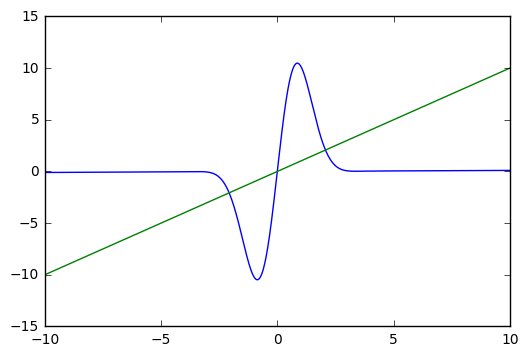

In [188]:
# ============================================================================== 
#                          Create the model 
# ==============================================================================

T = 500 #length of the HMM
multiDimensional = False #default value. Do not modify

#Specify Dimension of inputs and outputs
InputDimension = 0
StateDimension = 2
OutputDimension = 3



if InputDimension == 0:
    #We create an artificial input u , that is zero all the time
    InputDimension = 1
B = np.zeros([StateDimension,InputDimension])
D = np.zeros([OutputDimension,InputDimension])
mean = [0 for _ in range(StateDimension)] #where x[0] = normal(mean,Q)
mean_w = [0 for _ in range(StateDimension)] #do not change
mean_v = [0 for _ in range(OutputDimension)] #do not change

x = np.zeros((T,StateDimension))
y = np.zeros((T,OutputDimension))
u = np.zeros((T,InputDimension))
  

#-----------Define  f (from hidden state to output) and  h (from hidden state to output)----------------------------------

#Rmq: h should be of length OutputDimension
#Rmq: f should be of length StateDimension
choice_function = 4

# # function 1 : Gabor filter
if choice_function == 1:
    Q = np.identity(1) * 0.2
    R = np.identity(1) * 0.2
    f = lambda k,x_k: 0.01*x_k+20*np.sin(x_k)*np.exp(-x_k**2/2)
    C=3
    h = lambda k,x_k: C*x_k

# # function 2 : Well
if choice_function == 2:
    Q = np.identity(1) * 1
    R = np.identity(1) * 1
    f = lambda k,x_k: 0.9*x_k-50*np.exp(-x_k**2/2)+1
    C=3
    h = lambda k,x_k: C*x_k

# # function 3 : Sigmoid
if choice_function == 3:
    Q = np.identity(1) * 1
    R = np.identity(1) * 1
    f = lambda k,x_k:7*(1/(1+np.exp(-x_k))-0.5)
    C=3
    h = lambda k,x_k: C*x_k

# function 4 : Gabor filter multidimensional  #test in dimension > 1
if choice_function == 4:
    multiDimensional = True
    Q = np.identity(StateDimension) * 0.2
    R = np.identity(OutputDimension) * 0.2
    f = [lambda k,x_0,x_1: 0.01*x_0+20*np.sin(x_0)*np.exp(-x_0**2/2), lambda k,x_0,x_1: x_1]
    C = 3
    h = [lambda k,x_0,x_1: C*x_0, lambda k,x_0,x_1: x_1, lambda k,x_0,x_1: 1]
#I do not see any alternative other than f = list of functions (if I try to define f with a function 
#returning an array, I cannot retrieve the functions representing the components individually, but
#we need them in order to calculate their partial derivative. So for the moment we define multicomponent
#functions as list of functions of 1 dimension

#-----------------------------------------------------------------------------------------


# ============================================================================== 
#                           Print the function 
# ==============================================================================

absc = np.linspace(-10,10,1000)

if multiDimensional == False:
    ordo = f(1,absc)
if multiDimensional == True:
    to_plot = 0 #component of f to be plotted
    ordo = [f[to_plot](1,el,1) for el in absc] #specific for StateDimension = 2. Here we fix x1 = 1 and look at the evolution of f0 with x0

plt.figure()
plt.plot(absc,ordo)
plt.plot(absc,absc)
plt.show()

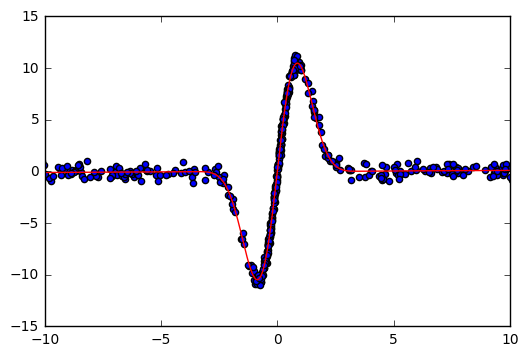

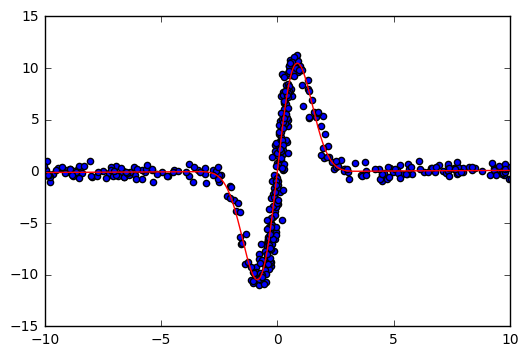

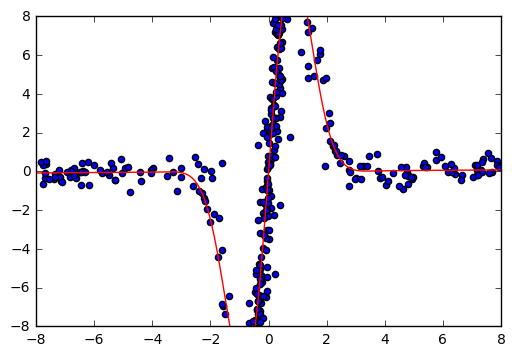

In [199]:
#Extended Kalman filter, with no parameter estimation

iterations = 1

x_it = np.zeros((iterations,T,StateDimension))
y_it = np.zeros((iterations,T,OutputDimension))
x_f_it = np.zeros((iterations,T,StateDimension))
x_b_it = np.zeros((iterations,T,StateDimension))

for i in range(iterations):    
#     x[0] = normal(mean,Q)
    x[0] = multivariate_normal(mean,Q) #initialisation

    #Propagation
    for k in range(T-1):
#         x[k+1] = f(k,x[k]) + np.dot(B,u[k]) + normal(mean,Q)
        x[k+1] = evaluate_f(f,[k,x[k]],multiDimensional) + np.dot(B,u[k]) + multivariate_normal(mean_w, Q)
    for k in range(T):
#         y[k] = h(k,x[k])  + np.dot(D,u[k]) + normal(mean,R)
        y[k] = evaluate_f(h,[k,x[k]],multiDimensional)  + np.dot(D,u[k]) + multivariate_normal(mean_v, R)
        
#     print(x.shape)
#     print(y.shape)
    x_it[i] = x #before it was written: x.flatten()
    y_it[i] = y
    
    print("Entering Extended Kalmann Filter")
    x_f,x_b = extended_KF(x[0],y,T,f,h,R,Q,StateDimension,OutputDimension)
    print("Exiting Extended Kalmann Filter")
    print(x_f.shape,x_b.shape)
    
    x_f_it[i] = x_f
    x_b_it[i] = x_b
    

absc = np.linspace(-10,10,T)
if multiDimensional == False:
    ordo = f(1,absc)
if multiDimensional == True:
    to_plot = 0 #component of f to be plotted
    ordo = [f[to_plot](1,el,1) for el in absc] #specific for StateDimension = 2. Here we fix x1 = 1 and look at the evolution of f0 with x0

    
plt.figure()
plt.plot(absc,ordo,c='r')
for i in range(iterations):
    plt.scatter(x_it[i,:-1,0],x_it[i,1:,0]) #looking at the evolution of the first component with time (actually, plotting points (x_t+1,x_t))
plt.xlim(-10,10)
#plt.savefig("graphs/x3.eps",format = "eps")
plt.show()

plt.figure()
plt.plot(absc,ordo,c='r')
for i in range(iterations):
    plt.scatter(x_f_it[i,:-1,0],x_f_it[i,1:,0]) #looking at the evolution of the first component with time
plt.xlim(-10,10)
plt.ylim(-15,15)
plt.show()

plt.figure()
plt.plot(absc,ordo,c='r')
#plt.plot(absc,absc)
for i in range(iterations):
    plt.scatter(x_b_it[i,:-1,0],x_b_it[i,1:,0]) #looking at the evolution of the first component with time
#plt.savefig("graphs/x3_b.eps",format = "eps")
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.show()



In [9]:
#Initialisation with factor analysis: test
    
# #Parameters of the sample which has to be inferred
# mean = 0
# Q=3
# R=3
# x[0] = normal(mean,Q)

# #Propagation
# for k in range(T-1):
#     x[k+1] = f(k,x[k]) + normal(mean,Q)
# for k in range(T):
#     y[k] = h(k,x[k]) + normal(mean,R)

# print(np.array(y).T.shape)
# factor_analysis(np.array(y).T,1)

In [52]:
np.random.seed(0)


#radial basis function compute exp(-beta * (c-x)^2)
def radialbasisfunc(beta, c, x):
    return exp(-beta * norm(c-x)**2)

def linearfunction(a,b,x):
    return a*x+b
     
#activation fills the Phi (in the pdf)
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    Phi = zeros((X.shape[0], numNeurons), float)
    for i, c in enumerate(centers):
        for j, x in enumerate(X):
            #Here we fill the element j,i with exp(-beta * (c_i-x_j)^2)
            Phi[j,i] = radialbasisfunc(beta, c, x)
    return Phi
     
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons,linear):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x OutputDimension
    
    n = X.shape[0]
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    print("shape centers",centers.shape)
    #centers = np.linspace(-8, 8, num=numNeurons)
    
    print "center", centers
    
    # calculate activations of RBFs
    if linear == 0:
        Phi = activation(X, beta, numNeurons, centers)
        Phi = np.append(Phi, X, axis =1)
        Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
    else:
        Phi = X
        Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
    
    Phi = Phi.T
    
    print(pinv(Phi).shape[0])
    print(pinv(Phi).shape[1])
    print(Y.shape[0])
        
    Y_t = Y.T
    
    # calculate output weights (pseudoinverse)
#     W = dot(pinv(Phi), Y) #written by Victor
    W = Y_t.dot(pinv(Phi))
    
    #Calculate the covariance matrix Q with formula (6.18) 
    J = 1 #We have J = 1 because of eq (6.15): hyp of gaussians with input u = 0
#     Q = 1/J * dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y)) #written by Victor
    
    Q = 1/J * (Y_t.dot(Y_t.T) - W.dot(Phi.dot(Y_t.T)))
#     print("shape",Q.shape)
    
    
    L = [W, Q, centers]
    
   
    #print W
    print Q
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis=1)
    Phi = Phi.T
    
    Y = Phi.T.dot(W.T) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    
    print Phi.shape[1]
    print W.shape[1]
    return Y



('shape centers', (25, 1))
center [[-2.66666667]
 [ 3.23232323]
 [ 5.73737374]
 [-3.31313131]
 [-5.81818182]
 [ 3.7979798 ]
 [ 1.45454545]
 [-4.52525253]
 [ 4.36363636]
 [-1.13131313]
 [-5.17171717]
 [-1.61616162]
 [ 0.48484848]
 [ 4.84848485]
 [-6.54545455]
 [-2.1010101 ]
 [ 6.94949495]
 [-7.83838384]
 [ 7.67676768]
 [-0.4040404 ]
 [ 6.3030303 ]
 [-3.95959596]
 [ 2.42424242]
 [ 5.25252525]
 [-7.27272727]]
100
27
100
[[ 68.90393041]]
100
27


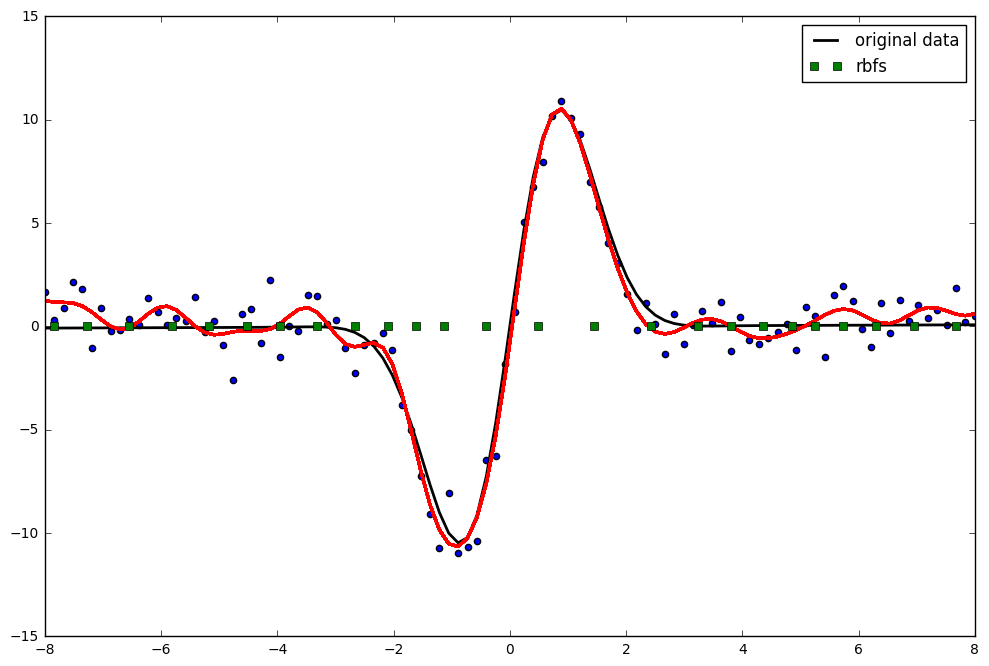

In [53]:
n = 100
     
#Define the bound of the focused interval    
lbound = -8
ubound = 8
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)

#--------------------Set y and add random noise---------------------------------

#Function 1
yOriginal = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
#yOriginal = 0.9*x-50*np.exp(-x**2/2)+1

yNoisy = yOriginal + random.normal(0, 1, yOriginal.shape)
# print("yNoisy",yNoisy)



f = [lambda k,x_0,x_1: 0.01*x_0+20*np.sin(x_0)*np.exp(-x_0**2/2), lambda k,x_0,x_1: x_1]
C = 3
h = [lambda k,x_0,x_1: C*x_0, lambda k,x_0,x_1: x_1, lambda k,x_0,x_1: 1]   

#----------------------------------------------------------------------------

#--------------Initialize parameters of the radial basis function-------------------
    
#Number of Gaussian centers(Neurons)
numNeurons = 25

#Define the size of the kernels 
beta = 1

#----------------------------------------------------------------------------

######################### Start RBF regression ##################################
linear = 0
#Train the neural network on the data x
parameters = trainrbf(x, yNoisy , beta, numNeurons, linear)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])
###############################################################################      
    
# plot original data
plt.figure(figsize=(12, 8))

# plot original data
plt.plot(x,yOriginal, 'k-', linewidth=2, label='original data')

for i in range(n):
    plt.scatter(x[i], yNoisy[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs', label = 'rbfs')

plt.legend()
plt.xlim(lbound, ubound)
plt.show()

#plt.savefig('graphs/RBF_2.jpg', format = 'jpg')

('shape centers', (15, 1))
center [[ 11.22817247]
 [  4.2181857 ]
 [ -9.51883512]
 [ -2.42677415]
 [ -0.29163883]
 [ -1.16072144]
 [  0.46494667]
 [ -6.65994942]
 [  6.29351464]
 [  8.5240065 ]
 [  3.06810512]
 [ -4.25985291]
 [  2.39051129]
 [  1.10595552]
 [  1.71106743]]
498
17
498
[[ 8404.23712761]]
('shape', (17, 1), (15, 1))
('shape centers', (15, 1))
center [[ 11.22817247]
 [ -9.58874634]
 [  4.20501781]
 [  2.83476795]
 [  1.840815  ]
 [  0.20444524]
 [ -4.18432729]
 [ -2.9616311 ]
 [ -1.85659974]
 [ -5.26545171]
 [  6.29351464]
 [  1.01109905]
 [ -0.74698158]
 [  8.5240065 ]
 [ -6.8174183 ]]
499
2
499
[[ 6222.55127825]]
('shape centers', (15, 1))
center [[ -3.13676898e+00]
 [  3.53445743e+00]
 [  7.50056218e+03]
 [ -5.60893311e-01]
 [  7.54709993e+00]
 [ -7.32180222e+00]
 [  1.34533276e+00]
 [  5.21954902e+00]
 [  1.06681607e+01]
 [  9.49022855e+01]
 [  2.30958276e+00]
 [ -4.82981894e+00]
 [ -1.69171542e+00]
 [  4.79976285e-01]
 [ -1.06574232e+01]]
498
17
498
[[ 8660.24535921]

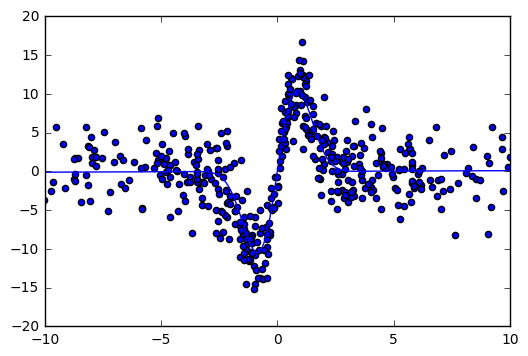

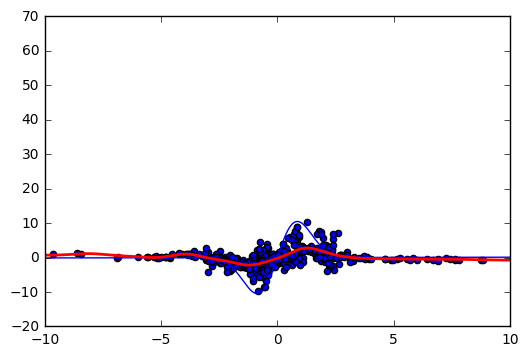

In [54]:
np.random.seed(0)

#EM algorithm

# x_k+1 = f(x_k) + w_k
# y_k = C*x_k + v_k

#Parameters of the sample which has to be inferred
mean = 0
Q=3
R=3

#x and y are the points we need to 
x = np.zeros((T,1))
y = np.zeros((T,1))


#We fix the number of kernel centers and the width of Gaussians

#Number of Gaussian centers(Neurons)
numNeurons = 15

#Define the size of the kernels 
beta = 1
Q_k=2.9
R_h=2.9

#Define the initial rbf with all weights equal to 1
W_k = np.ones(numNeurons+2)
centers = linspace(-8,8,numNeurons)

def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u
    
def h_rbf(k, y_k):
        return y_k * W_k[numNeurons] + W_k[numNeurons+1]


x[0] = normal(mean,Q)

#Propagation
for k in range(T-1):
    x[k+1] = f(k,x[k]) + normal(mean,Q)
for k in range(T):
    y[k] = h(k,x[k]) + normal(mean,R)

#Number of iterations 
maxIter = 8

#Start the EM algorithm
for t in range(maxIter):
    
    #E-Step
    
    #Input : f,h,Q,R, y_1, ..., y_T
    #Output : x_1,...,x_T
    
    
    iterations = 1

    x_f_it = np.zeros((iterations,T))
    x_b_it = np.zeros((iterations,T))

    for i in range(iterations):    
        
        #Start with the initial mean=0
        x[0] = normal(mean,Q_k)
        
        #Infer the states with non-linear Kalman filter
        x_f,x_b = extended_KF(x[0],y,T,f_rbf,h_rbf,R_h,Q_k)
        
        x_it[i] = x.flatten()
        y_it[i] = y.flatten()
    
        x_f_it[i] = x_f.flatten()
        x_b_it[i] = x_b.flatten()
        
    #M-Step
    
    #Input : x_1, ..., x_T, y_1,..., y_T
    #Output : f,h,Q,R
    
    #############################Fitting Input dynamics######################## 
    
    #Learn the state parameters
    
    #X represents x_k
    #Y represents x_{k+1}
    
    X = x_f[0:T-2]
    Y = x_f[1:T-1]
    
    #Train the rbf and learn the new parameters
    StateParameters = trainrbf(X,Y, beta, numNeurons,0)
    
    W_k = StateParameters[0].T
    Q_k = StateParameters[1] #estimation of Q
    centers = StateParameters[2]
    print("shape",W_k.shape,centers.shape)
    
    
    #Update the Radial basis function with the new centers and the new weights
    def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u
    #mean = W_k[numNeutrons+1]
    
    ############################################################################
    
    #############################Fitting Output dynamics######################## 
    
    X = x_f[0:T-1]
    Y = y[0:T-1]
    
    #Train the rbf and learn the new parameters
    OutputParameters = trainrbf(X,Y, beta, numNeurons,1)
    
    W_h = OutputParameters[0]
    R_h = OutputParameters[1] #Estimation of R
    
    def h_rbf(k, y_k):
        return y_k * W_h[0] + W_h[1]
    
    #############################################################################

absc = np.linspace(-15,15,T)
ordof = f(1,absc)
ordorbf = np.zeros(T)
for i in range(T):
    ordorbf[i] = f_rbf(1,absc[i])
    
#Plot the real states and the real function
plt.figure()
plt.plot(absc,ordof)
for i in range(iterations):
    plt.scatter(x_it[i,:-1],x_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

#Plot the infered states and the corresponding radial basis function
plt.figure()
plt.plot(absc,ordof)
plt.plot(absc,ordorbf, 'r-', linewidth=2)
for i in range(iterations):
    plt.scatter(x_f_it[i,:-1],x_f_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

        
plt.show()




In [43]:
import pandas as pd
import numpy as np
from scipy import *

#Specify Dimension of inputs and outputs
InputDimension = 0
StateDimension = 2
OutputDimension = 3

np.random.seed(0)

df = pd.read_csv('data/weather_madrid_LEMD_1997_2015.csv')
df = df[['CET', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC']]
df_usable = df.loc[df.index > 2459] #starts on 2004-02-01
data = df_usable[['Max TemperatureC', 'Min TemperatureC']]
data = np.array(data.as_matrix())
# print(data.shape)
month = np.reshape(np.array([(31. + i)%366 / 366 * 12 for i in range(data.shape[0])]),(T,1))
# print(month)

#Parameters of the sample which has to be inferred
mean = np.zeros((1,2))
Q=np.identity(2)
R=np.identity(2)

#Define the size of the kernels 
beta = 1
Q_k=np.identity(2)
R_h=np.identity(2)

T = data.shape[0]

#We fix the number of kernel centers and the width of Gaussians

#Number of Gaussian centers(Neurons)
numNeurons = 15

#Define the initial rbf with all weights equal to 1
W_k = np.ones(numNeurons+2)
centers = linspace(-8,8,numNeurons)

def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u
    
def h_rbf(k, y_k):
        return y_k * W_k[numNeurons] + W_k[numNeurons+1]

    
x = np.zeros((T,StateDimension))
x[0] = np.ones((1,StateDimension))
print(x)
y = np.concatenate([data,month],axis=1)
print(y.shape)


#Number of iterations 
maxIter = 8

#Start the EM algorithm
for t in range(maxIter):
    
    #E-Step
    
    #Input : f,h,Q,R, y_1, ..., y_T
    #Output : x_1,...,x_T
    
    
    iterations = 1

    x_f_it = np.zeros((iterations,T))
    x_b_it = np.zeros((iterations,T))

    for i in range(iterations):    
        
        #Start with the initial mean=0
        x[0] = multivariate_normal(mean[0],Q_k)
        
        #Infer the states with non-linear Kalman filter
        x_f,x_b = extended_KF(np.array([x[0]]),y,T,f_rbf,h_rbf,R_h,Q_k)
        
        x_it[i] = x.flatten()
        y_it[i] = y.flatten()
    
        x_f_it[i] = x_f.flatten()
        x_b_it[i] = x_b.flatten()
        
    #M-Step
    
    #Input : x_1, ..., x_T, y_1,..., y_T
    #Output : f,h,Q,R
    
    #############################Fitting Input dynamics######################## 
    
    #Learn the state parameters
    
    #X represents x_k
    #Y represents x_{k+1}
    
    X = x_f[0:T-2]
    Y = x_f[1:T-1]
    
    #Train the rbf and learn the new parameters
    StateParameters = trainrbf(X,Y, beta, numNeurons,0)
    
    W_k = StateParameters[0].T
    Q_k = StateParameters[1] #estimation of Q
    centers = StateParameters[2]
    print("shape",W_k.shape,centers.shape)
    
    
    #Update the Radial basis function with the new centers and the new weights
    def f_rbf(k, x_k):
        u=0
        for i in range(numNeurons):
            u += exp(-beta * norm(centers[i]-x_k)**2) * W_k[i]
        u += x_k * W_k[numNeurons] + W_k[numNeurons+1]
        return u
    #mean = W_k[numNeutrons+1]
    
    ############################################################################
    
    #############################Fitting Output dynamics######################## 
    
    X = x_f[0:T-1]
    Y = y[0:T-1]
    
    #Train the rbf and learn the new parameters
    OutputParameters = trainrbf(X,Y, beta, numNeurons,1)
    
    W_h = OutputParameters[0]
    R_h = OutputParameters[1] #Estimation of R
    
    def h_rbf(k, y_k):
        return y_k * W_h[0] + W_h[1]
    
    #############################################################################

absc = np.linspace(-15,15,T)
ordof = f(1,absc)
ordorbf = np.zeros(T)
for i in range(T):
    ordorbf[i] = f_rbf(1,absc[i])
    
#Plot the real states and the real function
plt.figure()
plt.plot(absc,ordof)
for i in range(iterations):
    plt.scatter(x_it[i,:-1],x_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

#Plot the infered states and the corresponding radial basis function
plt.figure()
plt.plot(absc,ordof)
plt.plot(absc,ordorbf, 'r-', linewidth=2)
for i in range(iterations):
    plt.scatter(x_f_it[i,:-1],x_f_it[i,1:])
plt.xlim(-10,10)
#plt.ylim(-25,25)

        
plt.show()



[[ 1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
(4352, 3)


ValueError: setting an array element with a sequence.